## Familiarization of TNG Data Acess
### Goals

* Graph 3D time-dependent distribution of things (e.g. stellar mass, Europeum, star formation rate)

In [32]:
import requests
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors
import matplotlib.ticker as ticker
import os

In [33]:
cwd = os.getcwd()

In [3]:
%matplotlib inline

In [4]:
base_url = 'http://www.tng-project.org/api/'
headers = {'api-key': '869b608c817d0a731e5439be3345bdf7'}

In [5]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [6]:
r = get(base_url)
name_list = [sim['name'] for sim in r['simulations']]
index = name_list.index('TNG100-3')
sim = get(r['simulations'][index]['url'])

In [7]:
#Getting particular subhalo
snaps_json = get(sim['snapshots'])
num_snaps = len(snaps_json)

The following code block and current markdown is for testing purposes it can be removed later

## Graphing of Data
### 1D Distributions

In [8]:
#Inits
vars_list, snap_num_list = [], [] #Should have tuples of sfr, stellar_mass, and mass of NSNS
subhalo_id = 13
param_target = 'GFM_MetalsTagged'
metal_num = 3
params = {'stars':param_target, 'gas':param_target}


for i in range(0, num_snaps):

    snap = get(snaps_json[i]['url'])
    snap_num_list.append(snap['number'])
    subhalos_json = get(snap['subhalos'], {'limit':'100'})
    sfr, stellar_mass, metal_total = None, None, 0
    if subhalos_json['count'] > subhalo_id:
        
        try:
            subhalo = get(subhalos_json['results'][subhalo_id]['url'])
            sfr, stellar_mass = subhalo['sfr'], subhalo['mass_stars']

            try:
                subhalo_cutout = get(subhalo['cutouts']['subhalo'], params)

                #Opens hd5f file and takes out amount of metal
                with h5py.File(subhalo_cutout, 'r') as f:
                    metals_star = f['PartType4'][param_target]
                    metals_gas = f['PartType0'][param_target]
                    for metal_array in metals_star: metal_total += metal_array[metal_num]
                    for metal_array in metals_gas: metal_total += metal_array[metal_num]

            except: #Catches HTTP error but for some reason I could not install urllib2 on my server
                pass

        except IndexError:
            pass
        
    
    vars_list.append((sfr, stellar_mass, metal_total))

In [9]:
sfr_list, stellar_mass_list, metal_list = zip(*vars_list)

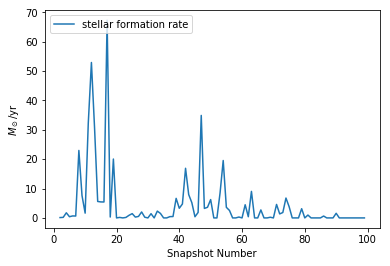

In [10]:
plt.plot(snap_num_list, sfr_list, label = 'stellar formation rate')
plt.xlabel('Snapshot Number')
plt.ylabel('$M_\odot$/yr')
plt.legend(loc='upper left')
plt.show()

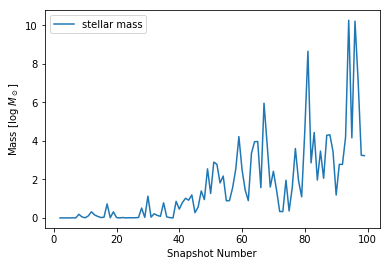

In [11]:
plt.plot(snap_num_list, stellar_mass_list, label = 'stellar mass')
plt.xlabel('Snapshot Number')
plt.ylabel('Mass [log $M_\odot$]')
plt.legend(loc='upper left')
plt.show()

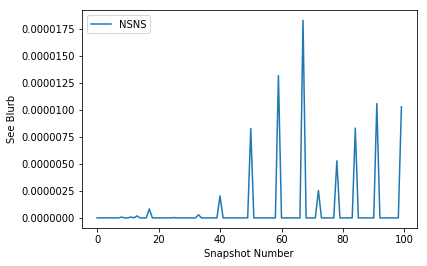

In [12]:
plt.plot(snap_num_list, metal_list, label = 'NSNS')
plt.xlabel('Snapshot Number')
plt.ylabel('See Blurb')
plt.legend(loc='upper left')
plt.show()

### 3D Distributions

In [8]:
def get_NSNS(snap_num, subhalo_id, matter_type):
    #Inits
    pos_list, snap_num_list = [], []
    param_target_1 = 'GFM_MetalsTagged'
    param_target_2 = 'Coordinates' 
    total_param = param_target_1 + ',' + param_target_2
    params = {matter_type:total_param}
    snap = get(snaps_json[snap_num]['url'])
    snap_num_list.append(snap['number'])
    subhalos_json = get(snap['subhalos'])
    metal_num = 3 #For NSNS

    NSNS_pos_amt_list = []

    try: #Subhalo doesn't exist
        subhalo = get(subhalos_json['results'][subhalo_id]['url'])
    except IndexError:
        return None

    try: #Cutout doesn't exist
        subhalo_cutout = get(subhalo['cutouts']['subhalo'], params)
    except: #HTTP error
        return None


    #Opens hd5f file and takes out amount of metal
    with h5py.File(subhalo_cutout, 'r') as f:
        if matter_type == 'stars': part_type = 'PartType4'
        if matter_type == 'gas': part_type = 'PartType0'
        metals = f[part_type][param_target_1][:]
        part_pos = f[part_type][param_target_2][:]

        num_particles = len(part_pos)
        for i in range(0, num_particles):
            NSNS_pos_amt_list.append((part_pos[i], metals[i][metal_num]))
            
    if NSNS_pos_amt_list == []: #Sometimes it comes up with empty query
        return None

            
    return NSNS_pos_amt_list

In [9]:
subhalo_id = 13
snap_num = 99
NSNS_star_pos_amt_list = get_NSNS(snap_num, subhalo_id, 'stars')
NSNS_gas_pos_amt_list = get_NSNS(snap_num, subhalo_id, 'gas')

In [10]:
#Converting into more useable data type, try catch incase no gas/star particles
def unwrap_data(arg):
    
    if arg == None: return None, None, None, None
    
    x_list, y_list, z_list = zip(*(element[0] for element in arg))
    NSNS_list = [element[1] for element in arg]

    return x_list, y_list, z_list, NSNS_list

In [16]:
star_x_list, star_y_list, star_z_list, star_NSNS_list = unwrap_data(NSNS_star_pos_amt_list)
gas_x_list, gas_y_list, gas_z_list, gas_NSNS_list = unwrap_data(NSNS_gas_pos_amt_list)

Below is the code for a plot of a single snapshot for a particular subhalo. The color bar displays how much NSNS material is in each particl

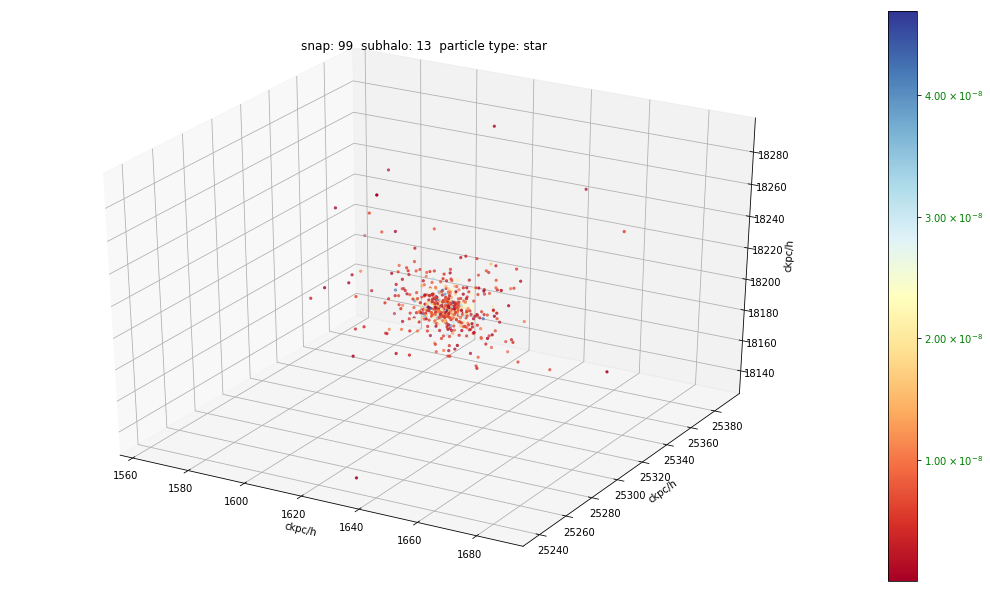

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')

min_NSNS, max_NSNS = min(star_NSNS_list), max(star_NSNS_list)

cm = plt.cm.get_cmap('RdYlBu')

star_plot = ax.scatter(star_x_list, star_y_list, star_z_list, s=5, c=star_NSNS_list, vmin=min_NSNS, vmax=max_NSNS, cmap=cm)
ax.set_xlabel('ckpc/h')
ax.set_ylabel('ckpc/h')
ax.set_zlabel('ckpc/h')
ax.set_title('snap: {}  subhalo: {}  particle type: {}'.format(snap_num, subhalo_id, 'star'))

#When you attach as email, the background is white so I had to change colobar tick colors
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
color_bar = plt.colorbar(star_plot, format=ticker.FuncFormatter(fmt))                   
cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')
plt.setp(cbytick_obj, color='g')
fig.set_size_inches(18.5, 10.5)

## Animation

In [40]:
snap_x, snap_y, snap_z, snap_NSNS = [], [], [], []
snap_list = []
subhalo_id = 26
for snap_id in range(0, num_snaps):
    wrapped_data = get_NSNS(snap_id, subhalo_id, 'gas')
    
    x_list, y_list, z_list, NSNS_list = unwrap_data(wrapped_data)
    
    if x_list == None: continue
    snap_list.append(snap_id)
    snap_x.append(x_list); snap_y.append(y_list); snap_z.append(z_list); snap_NSNS.append(NSNS_list)       
   

<IPython.core.display.Javascript object>


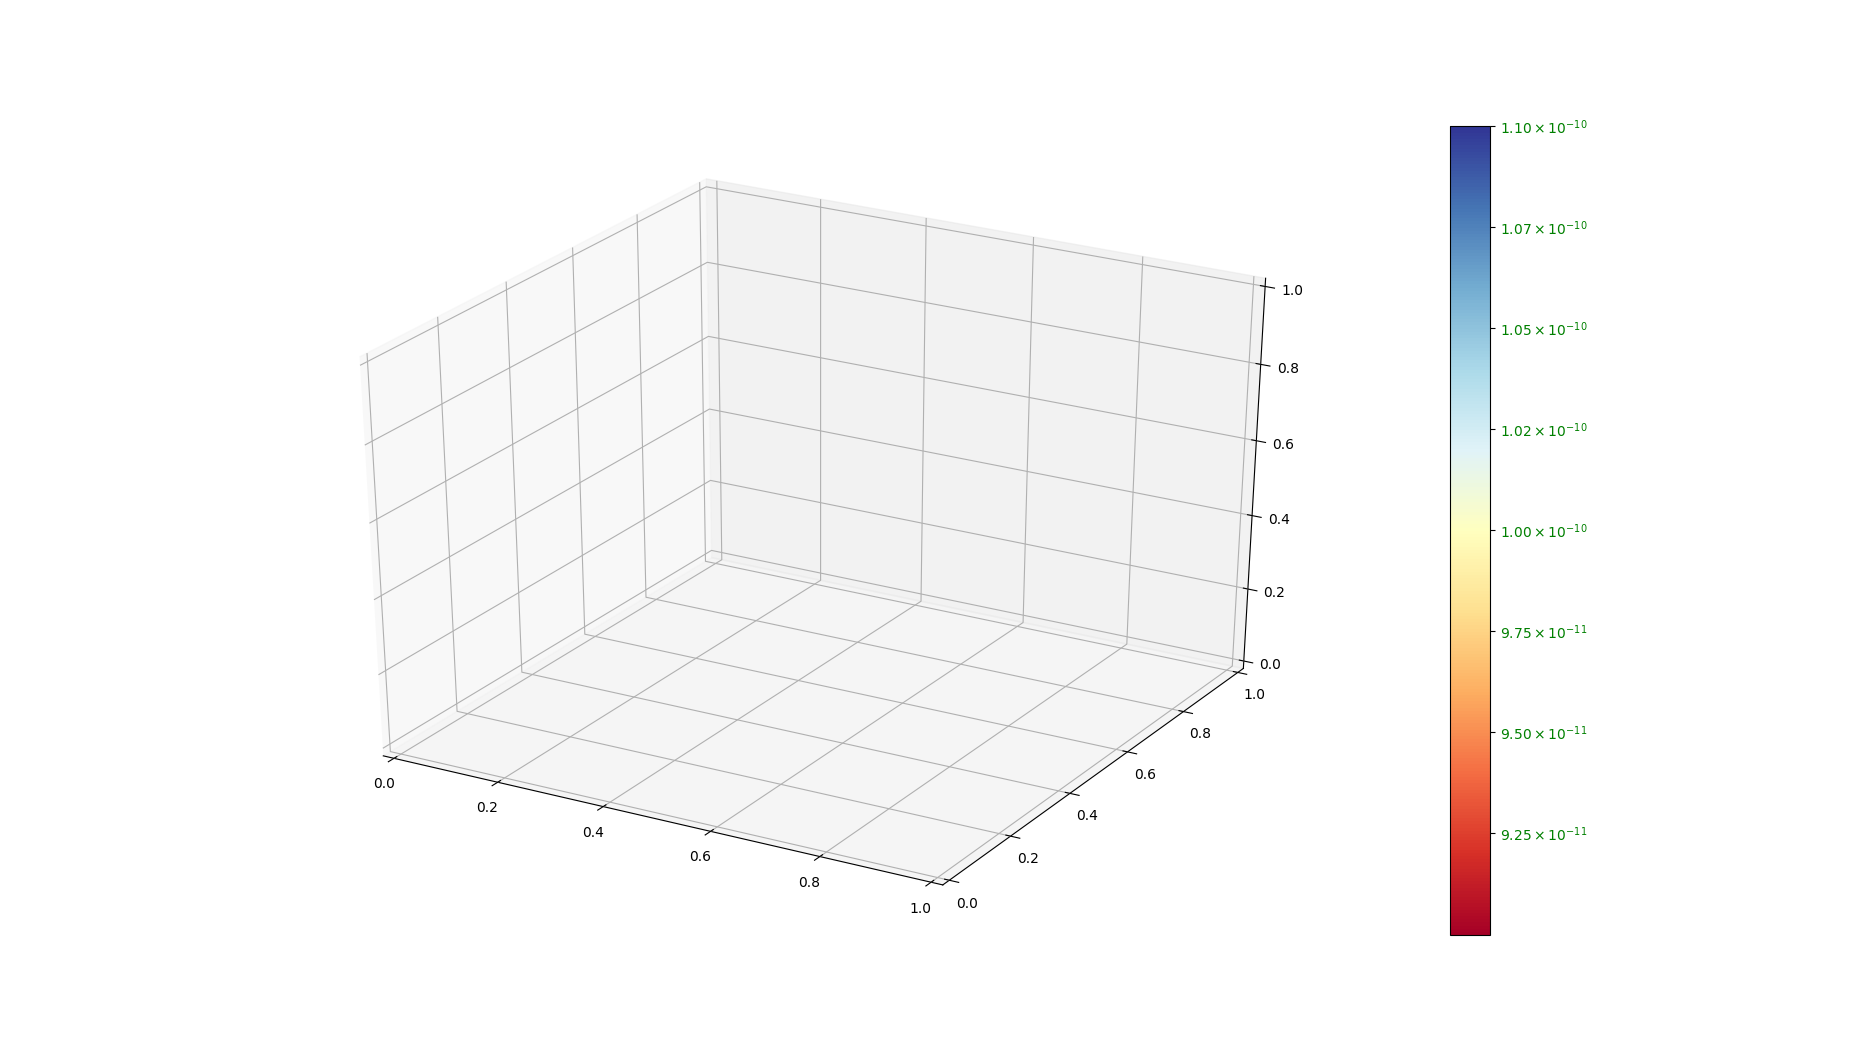

<IPython.core.display.Javascript object>


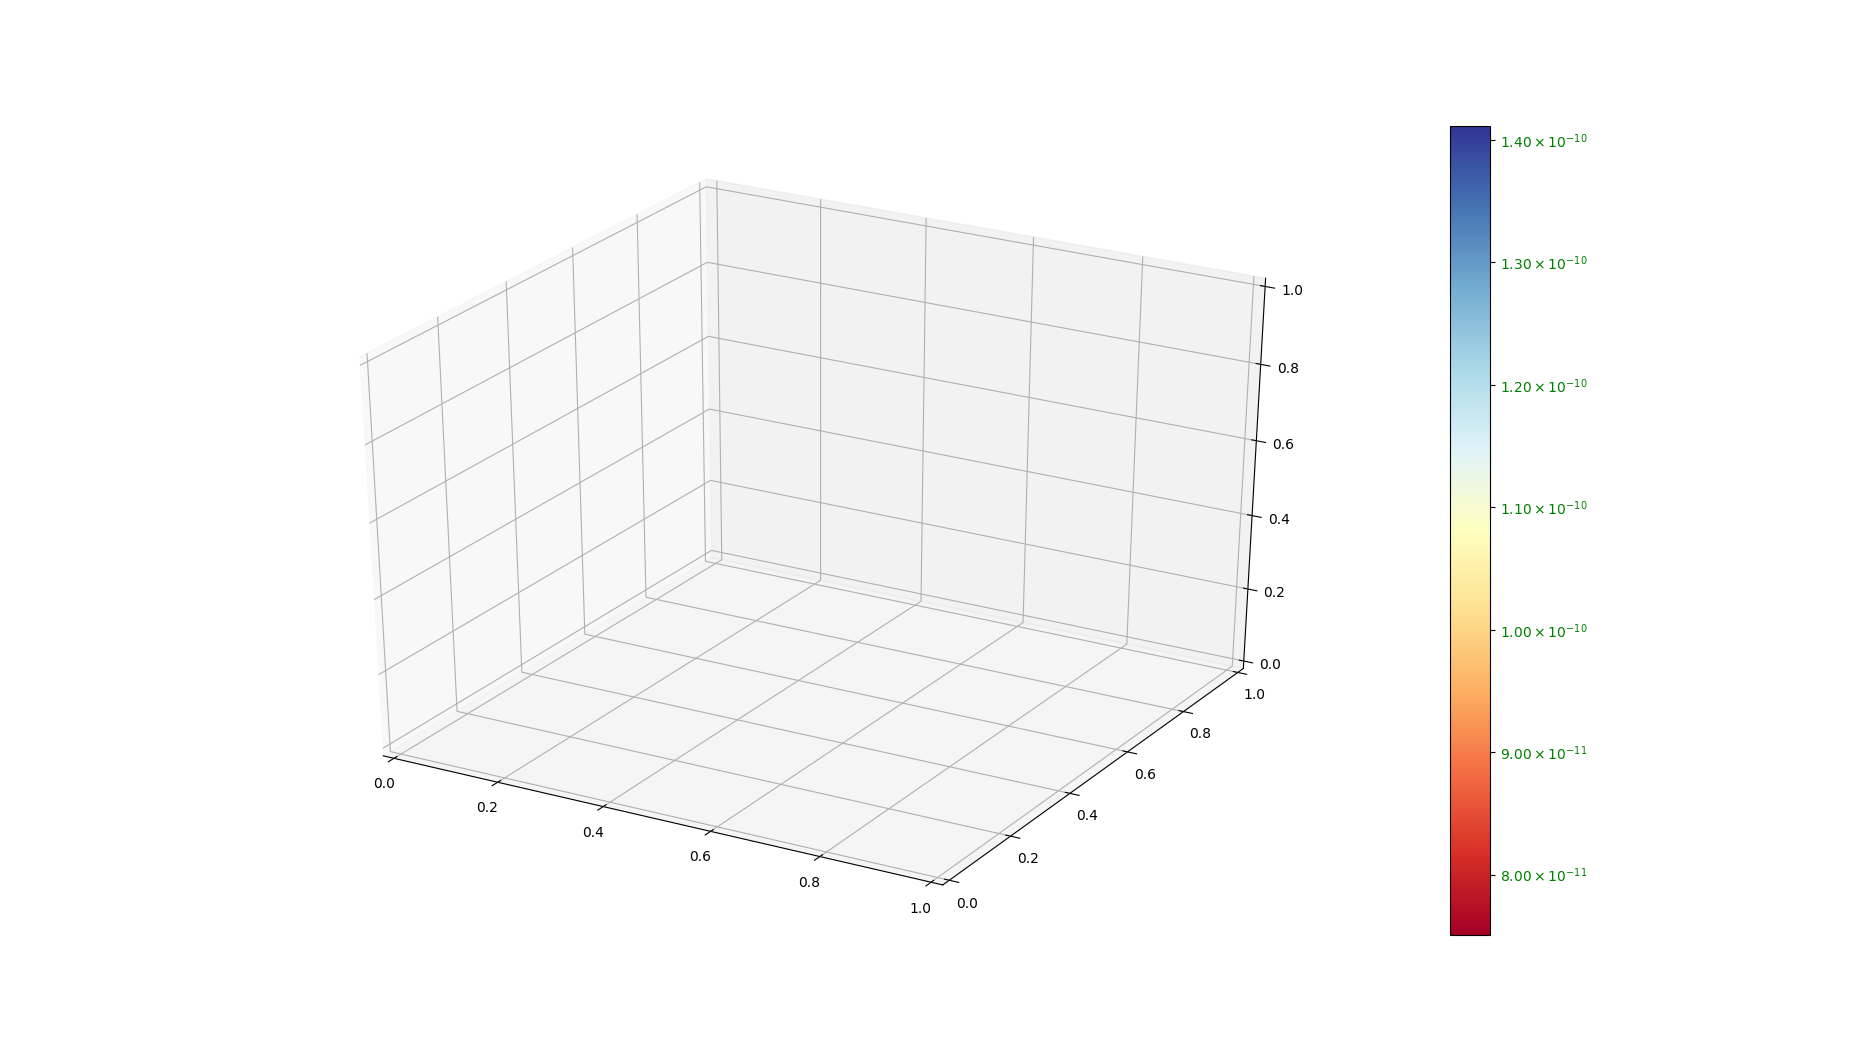

<IPython.core.display.Javascript object>


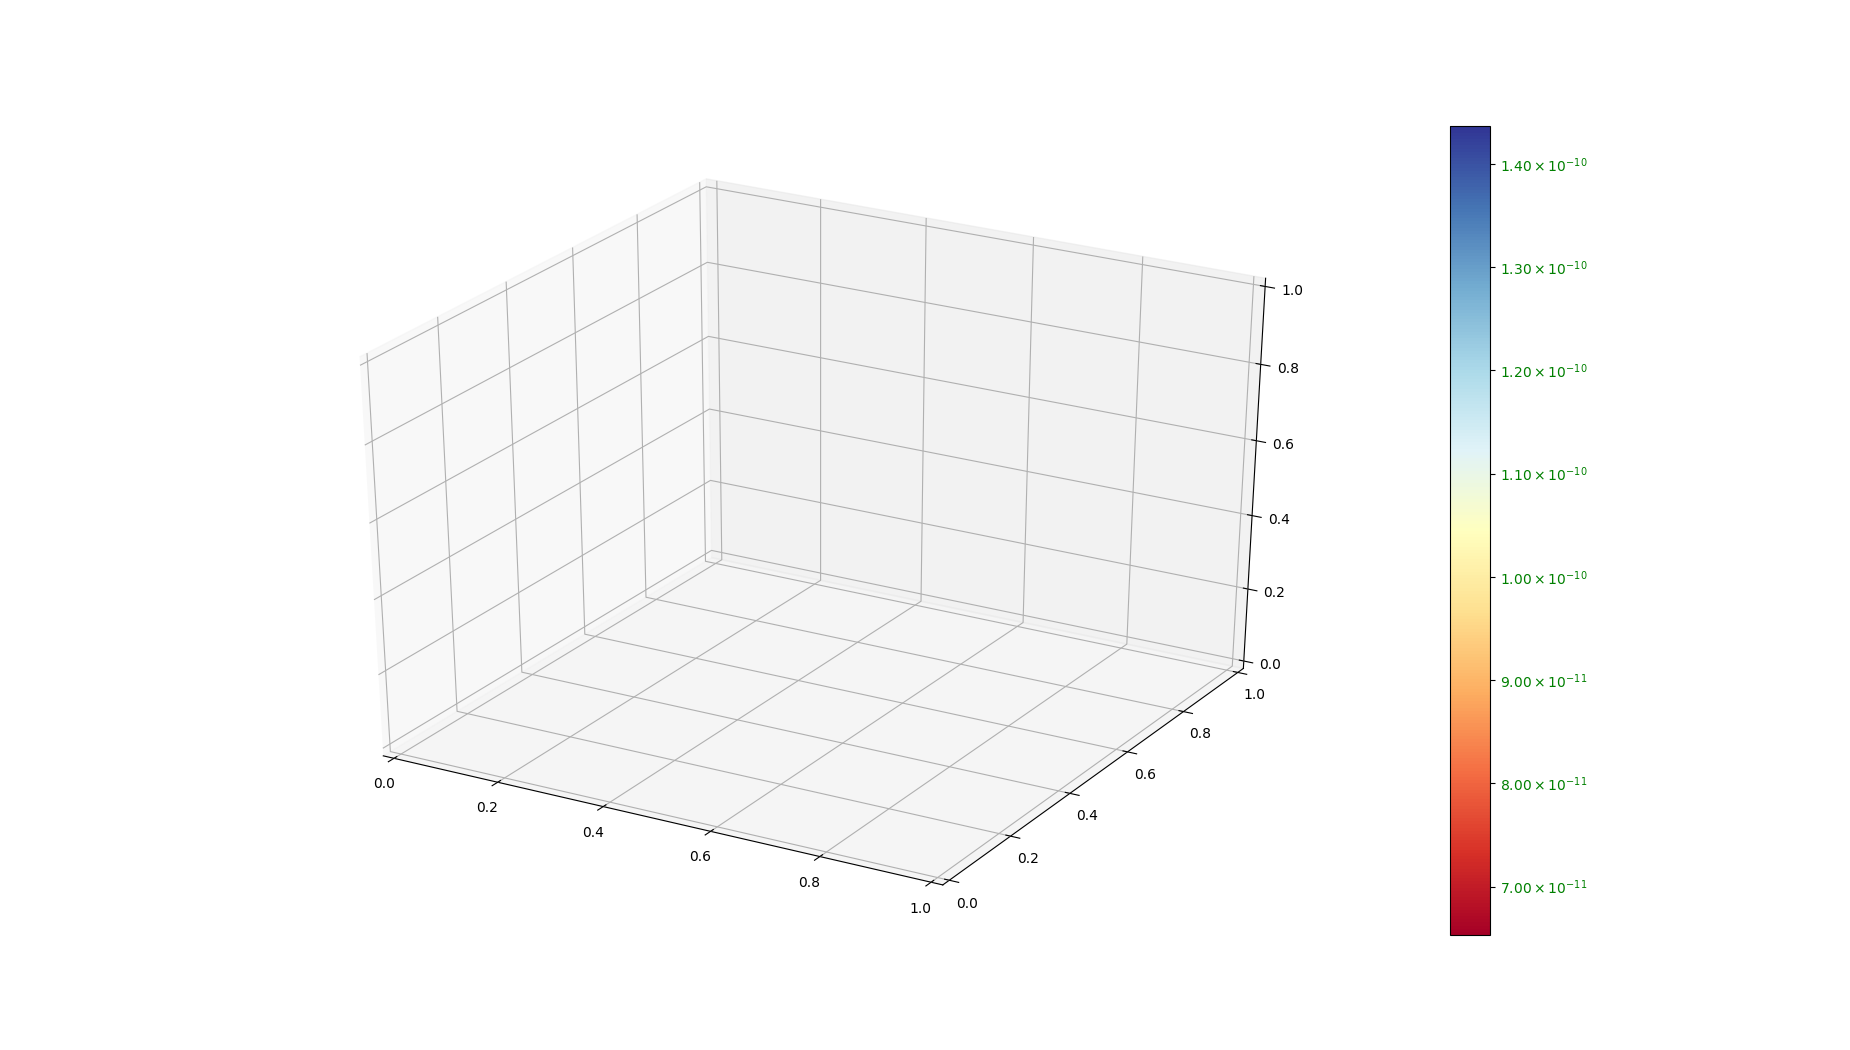

<IPython.core.display.Javascript object>


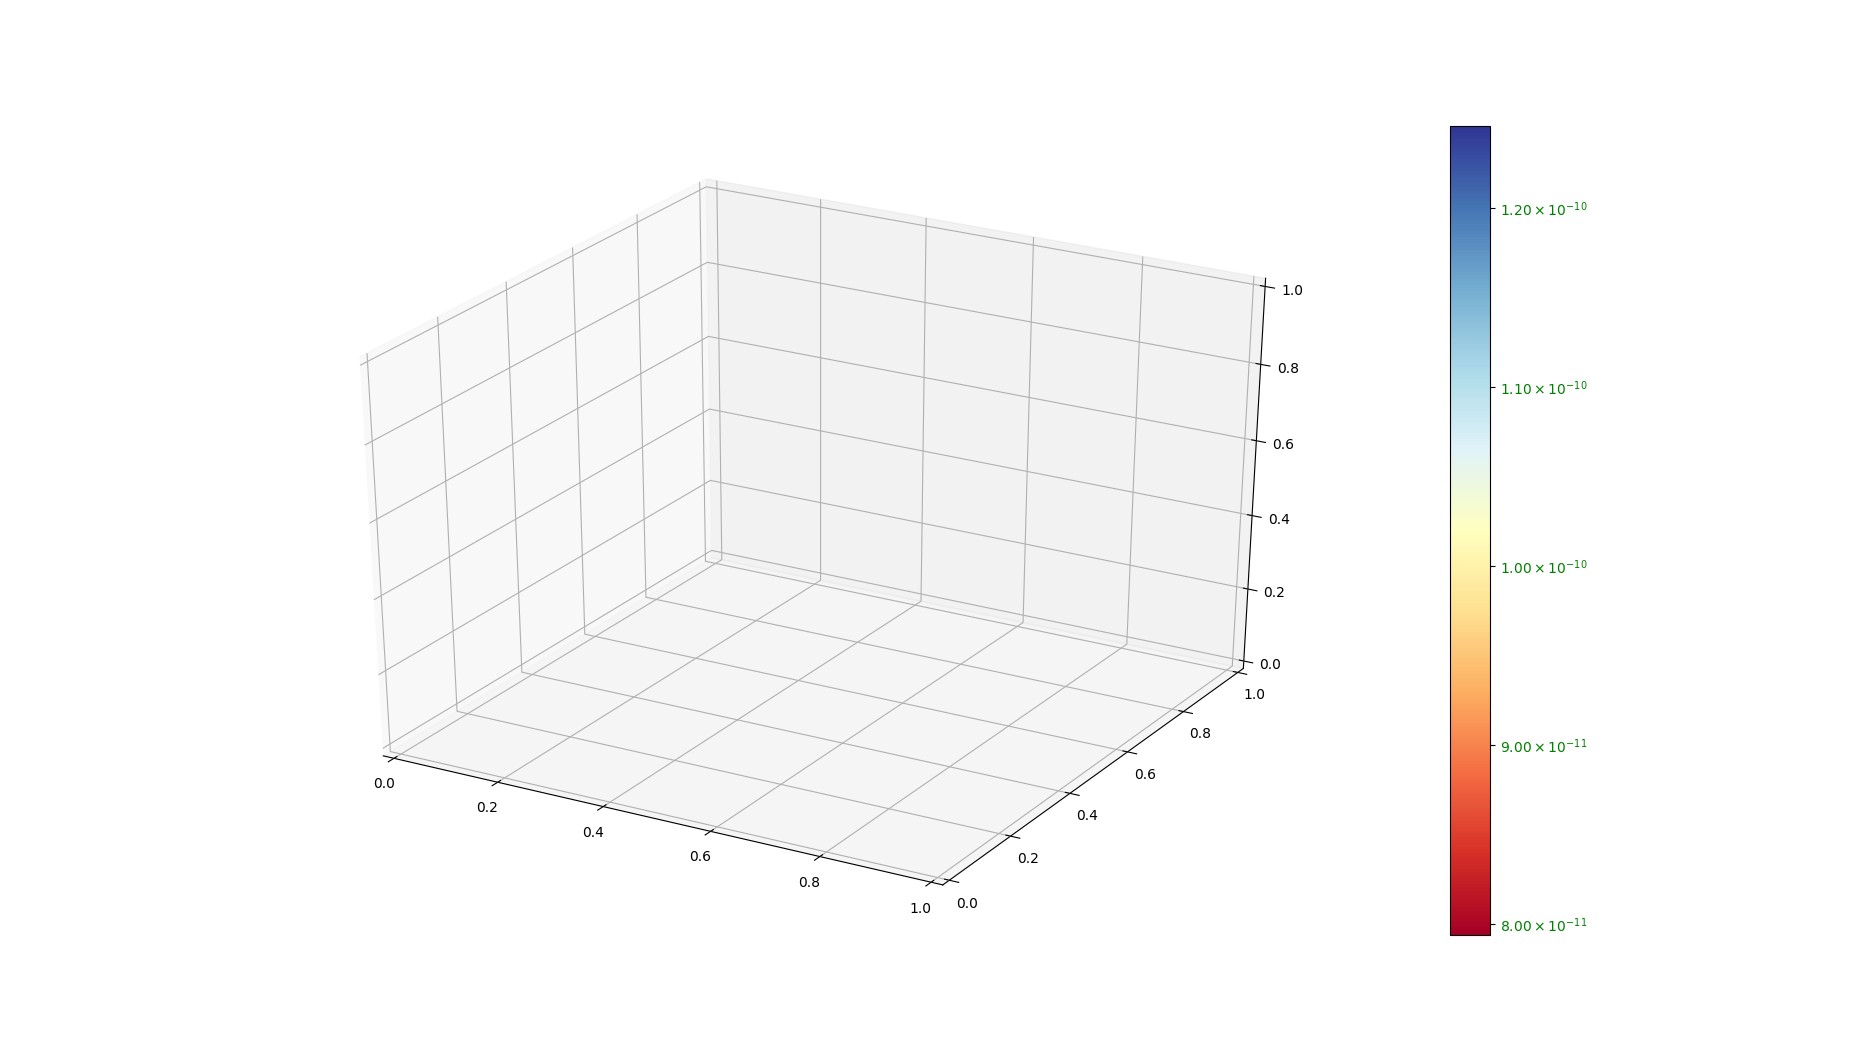

<IPython.core.display.Javascript object>


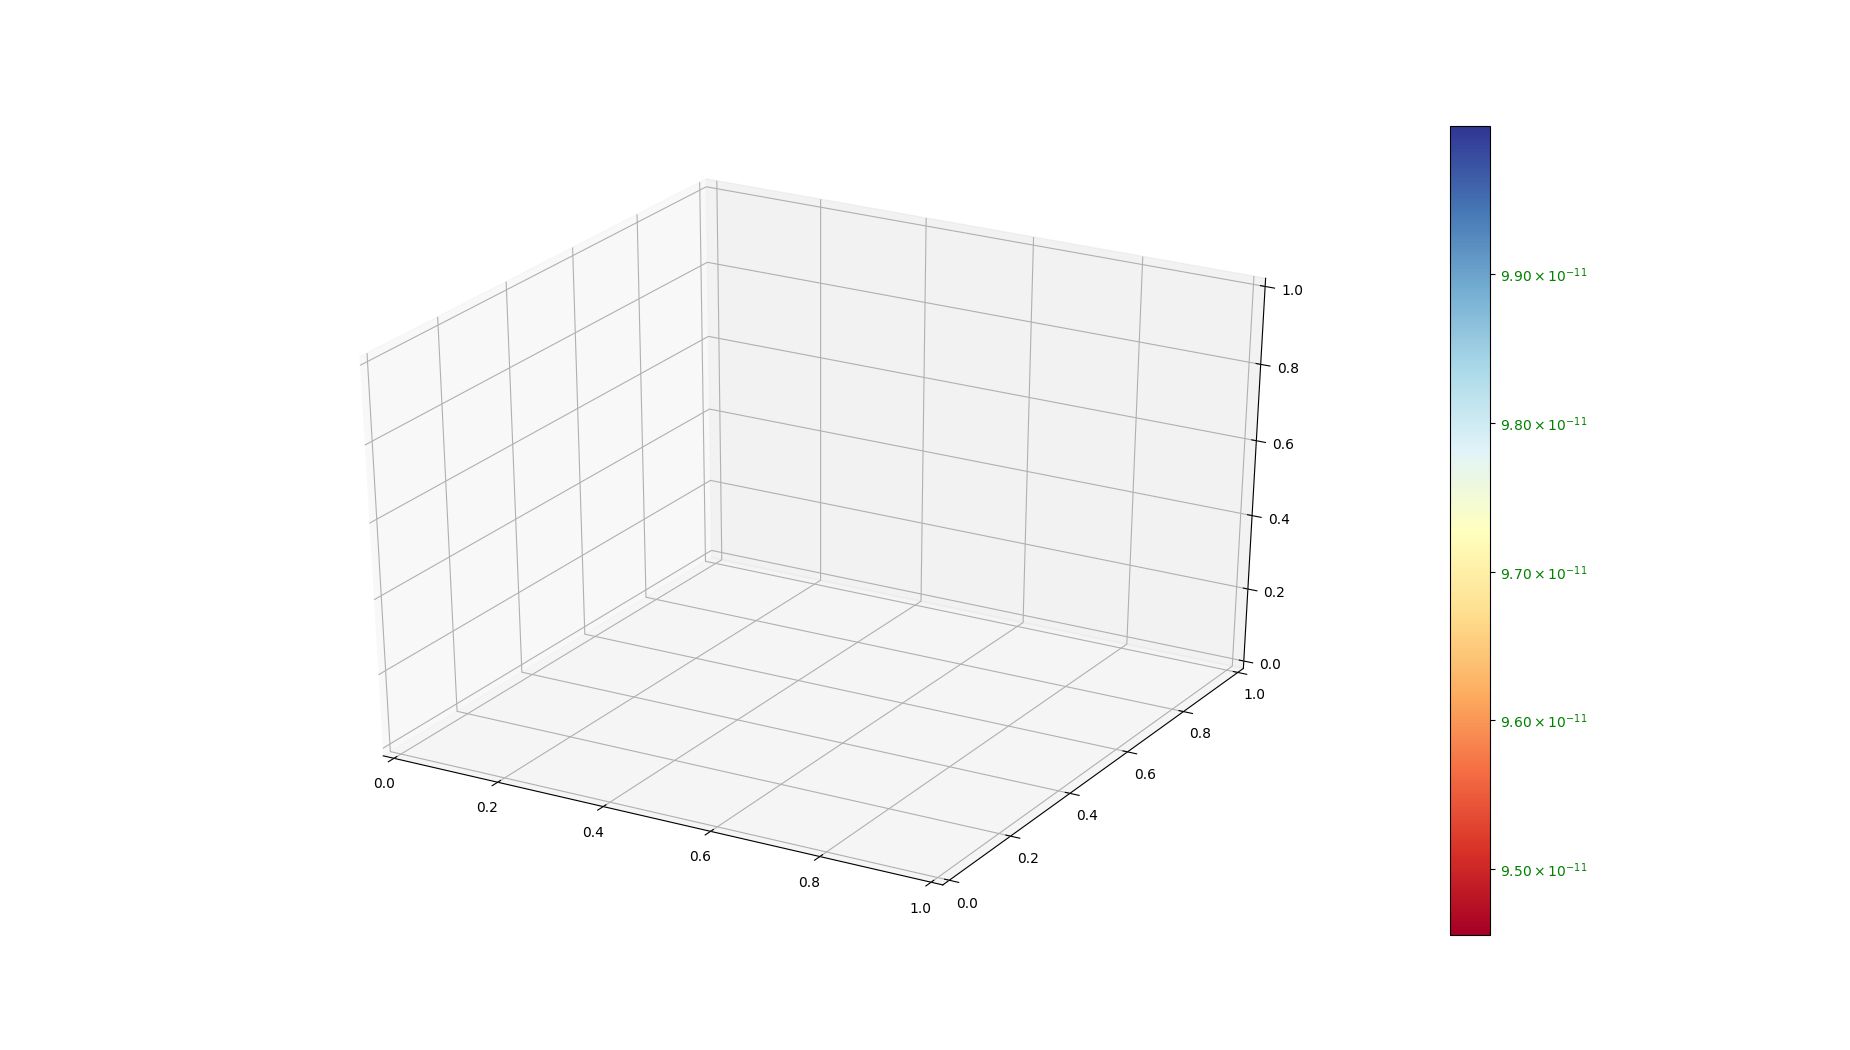

<IPython.core.display.Javascript object>


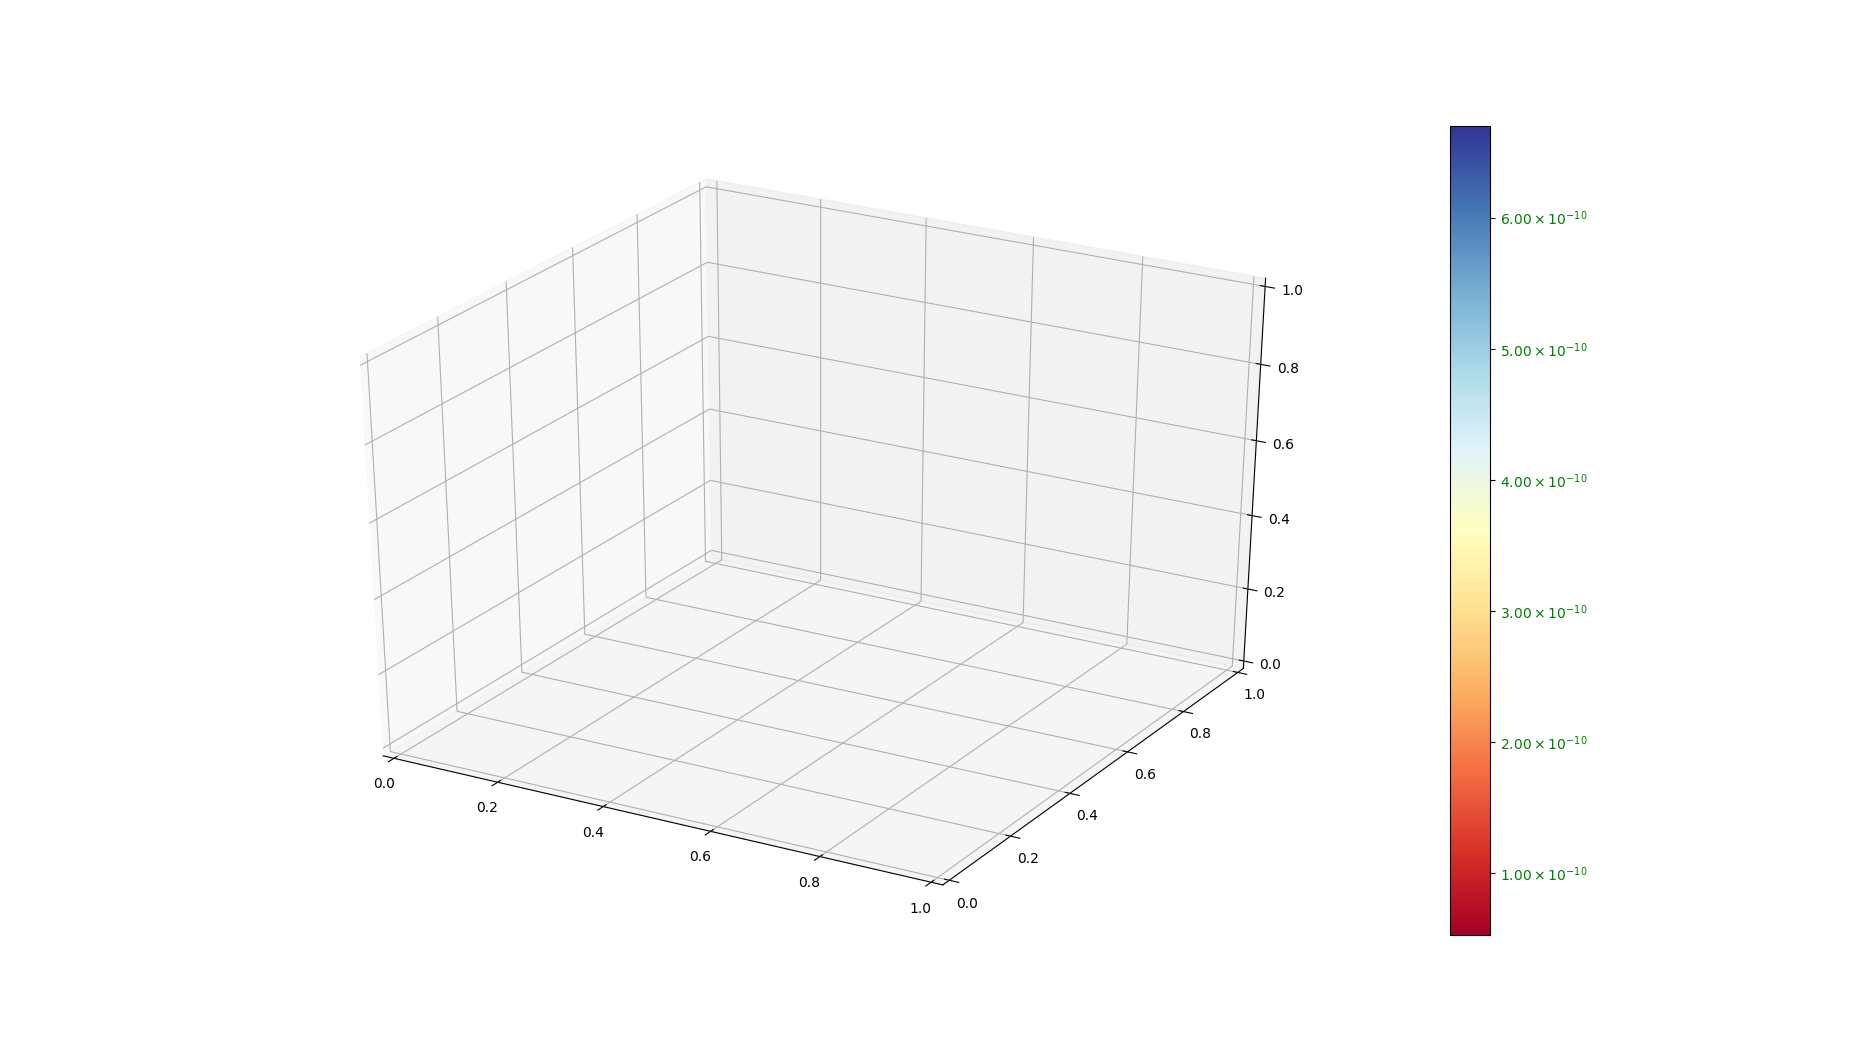

/home/n/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


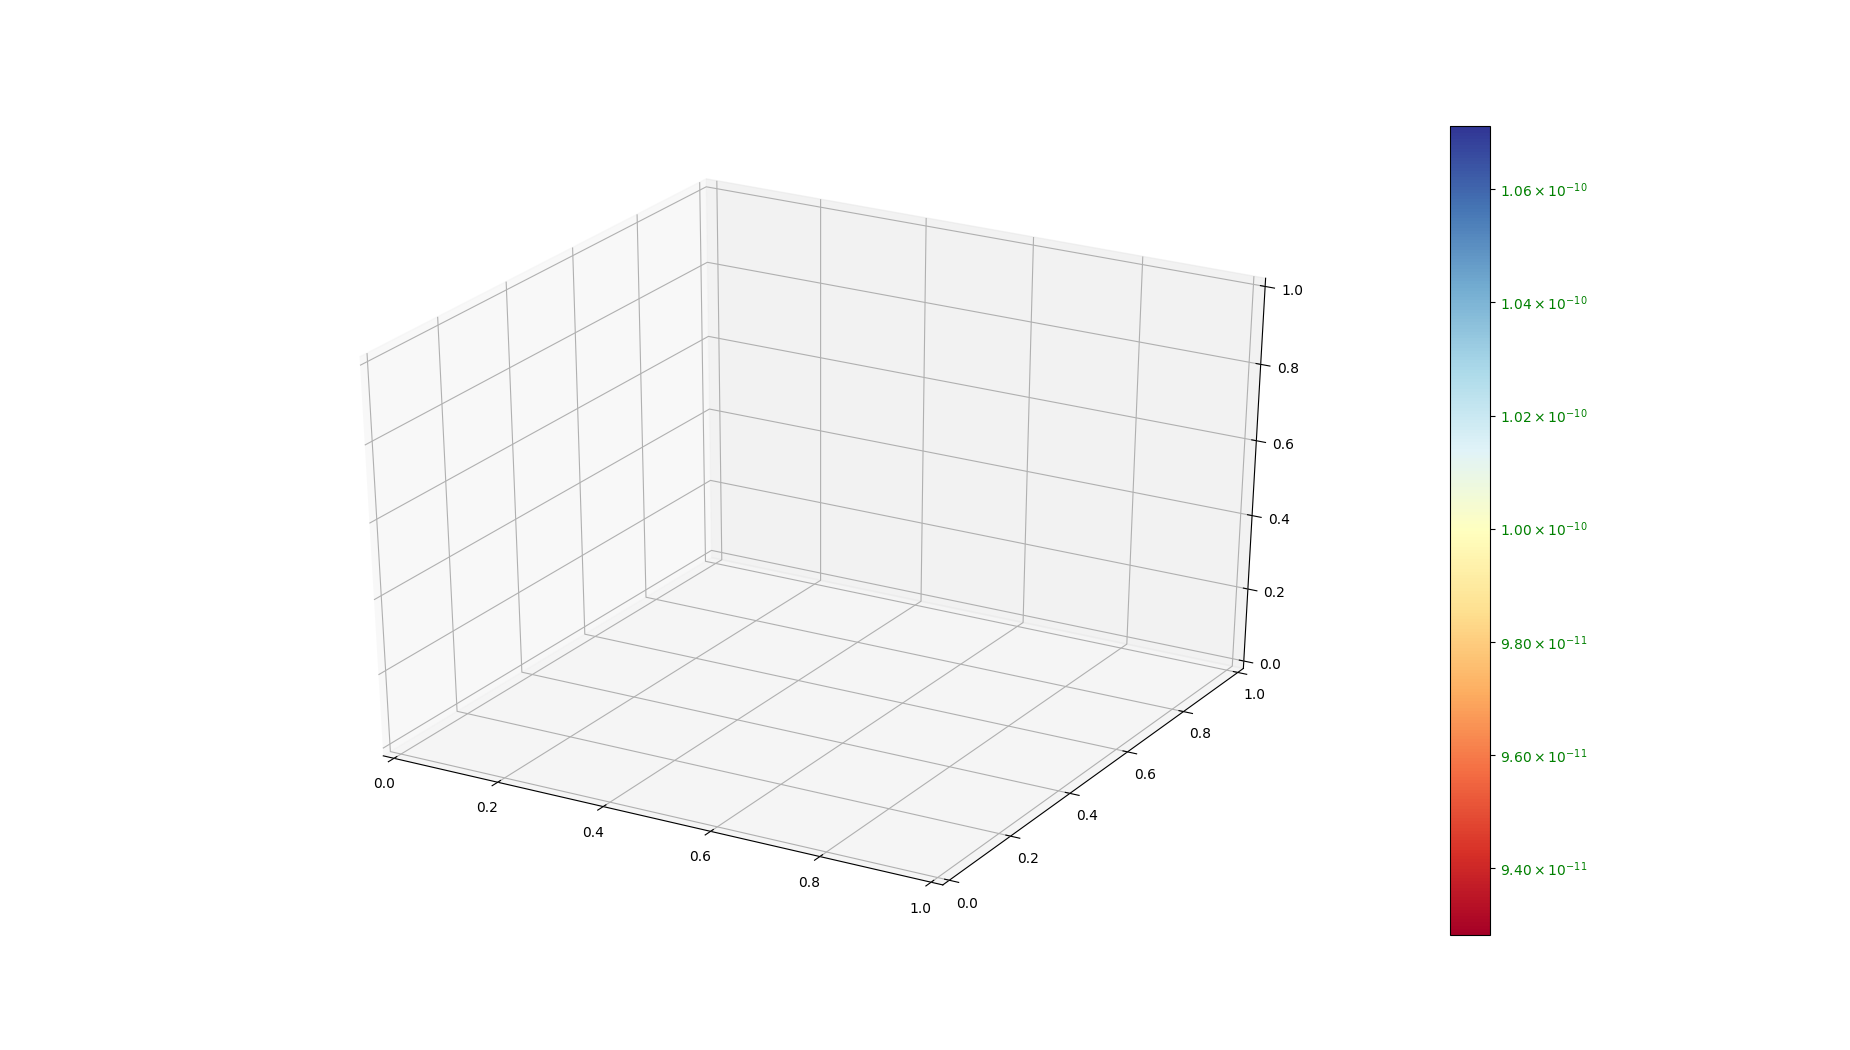

<IPython.core.display.Javascript object>


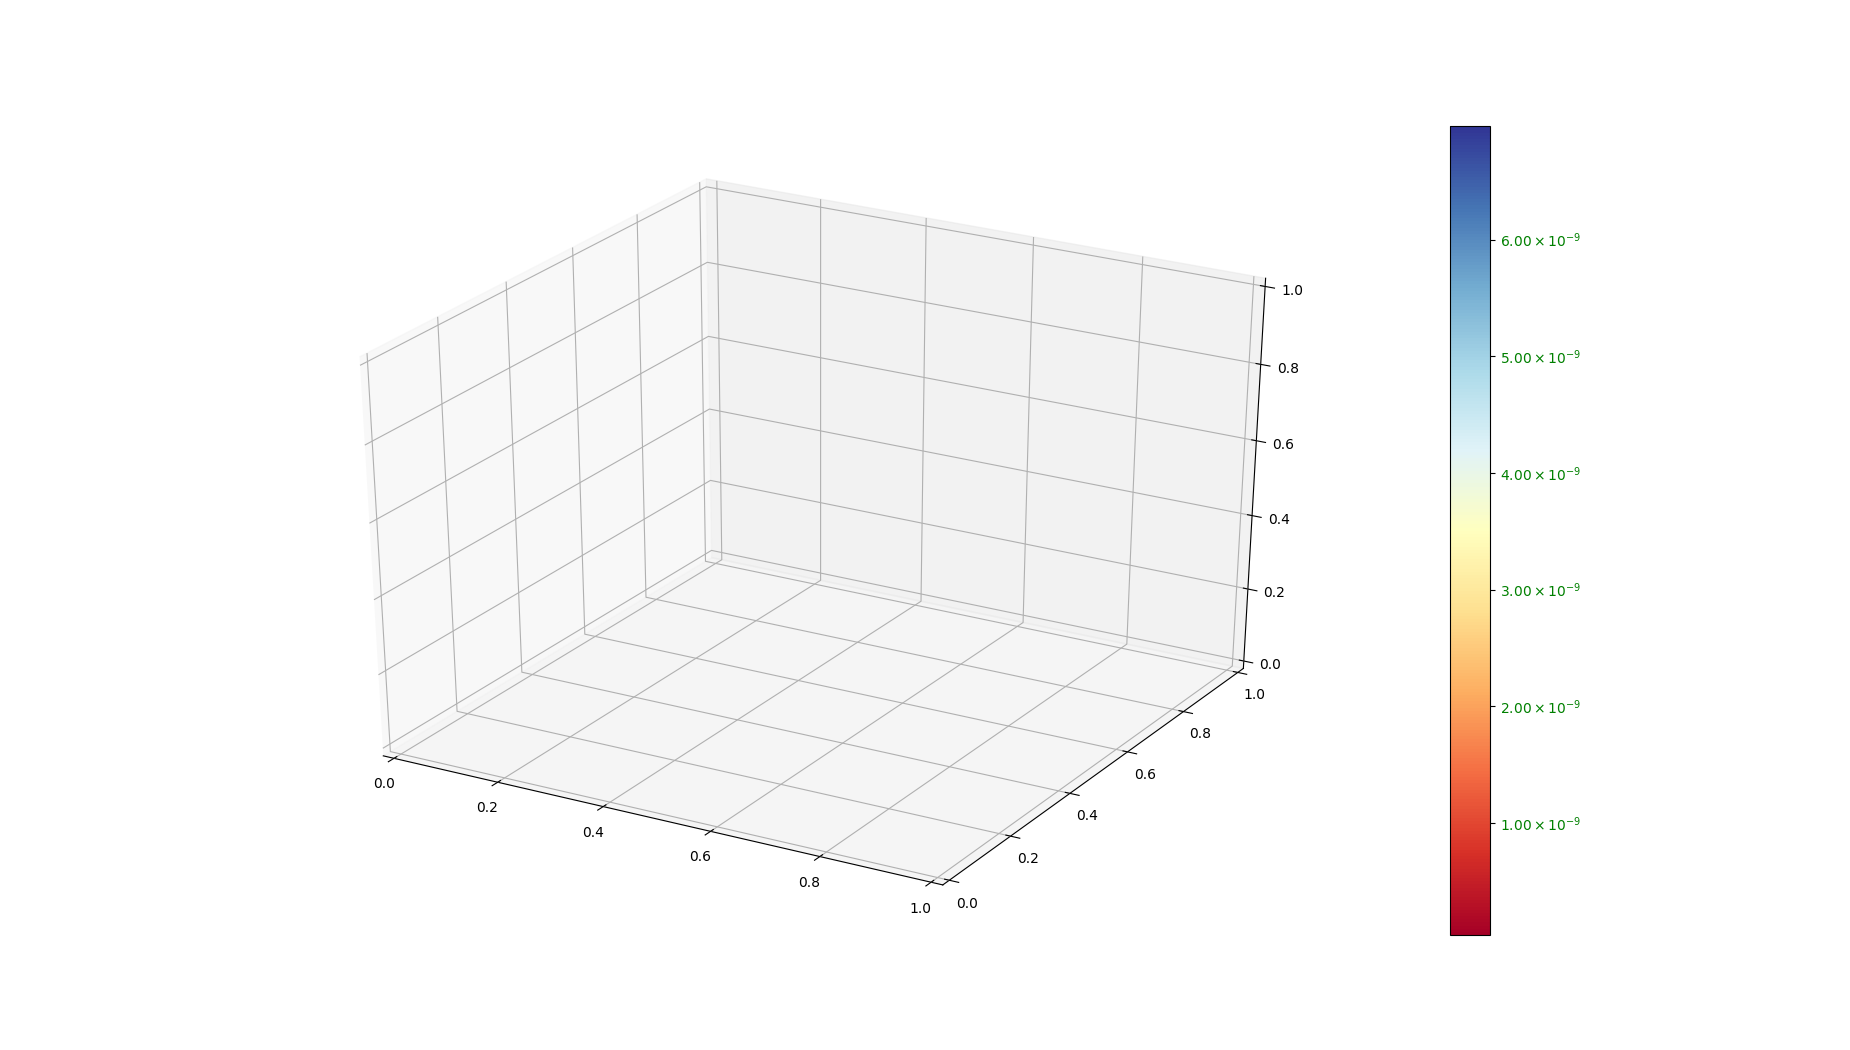

<IPython.core.display.Javascript object>


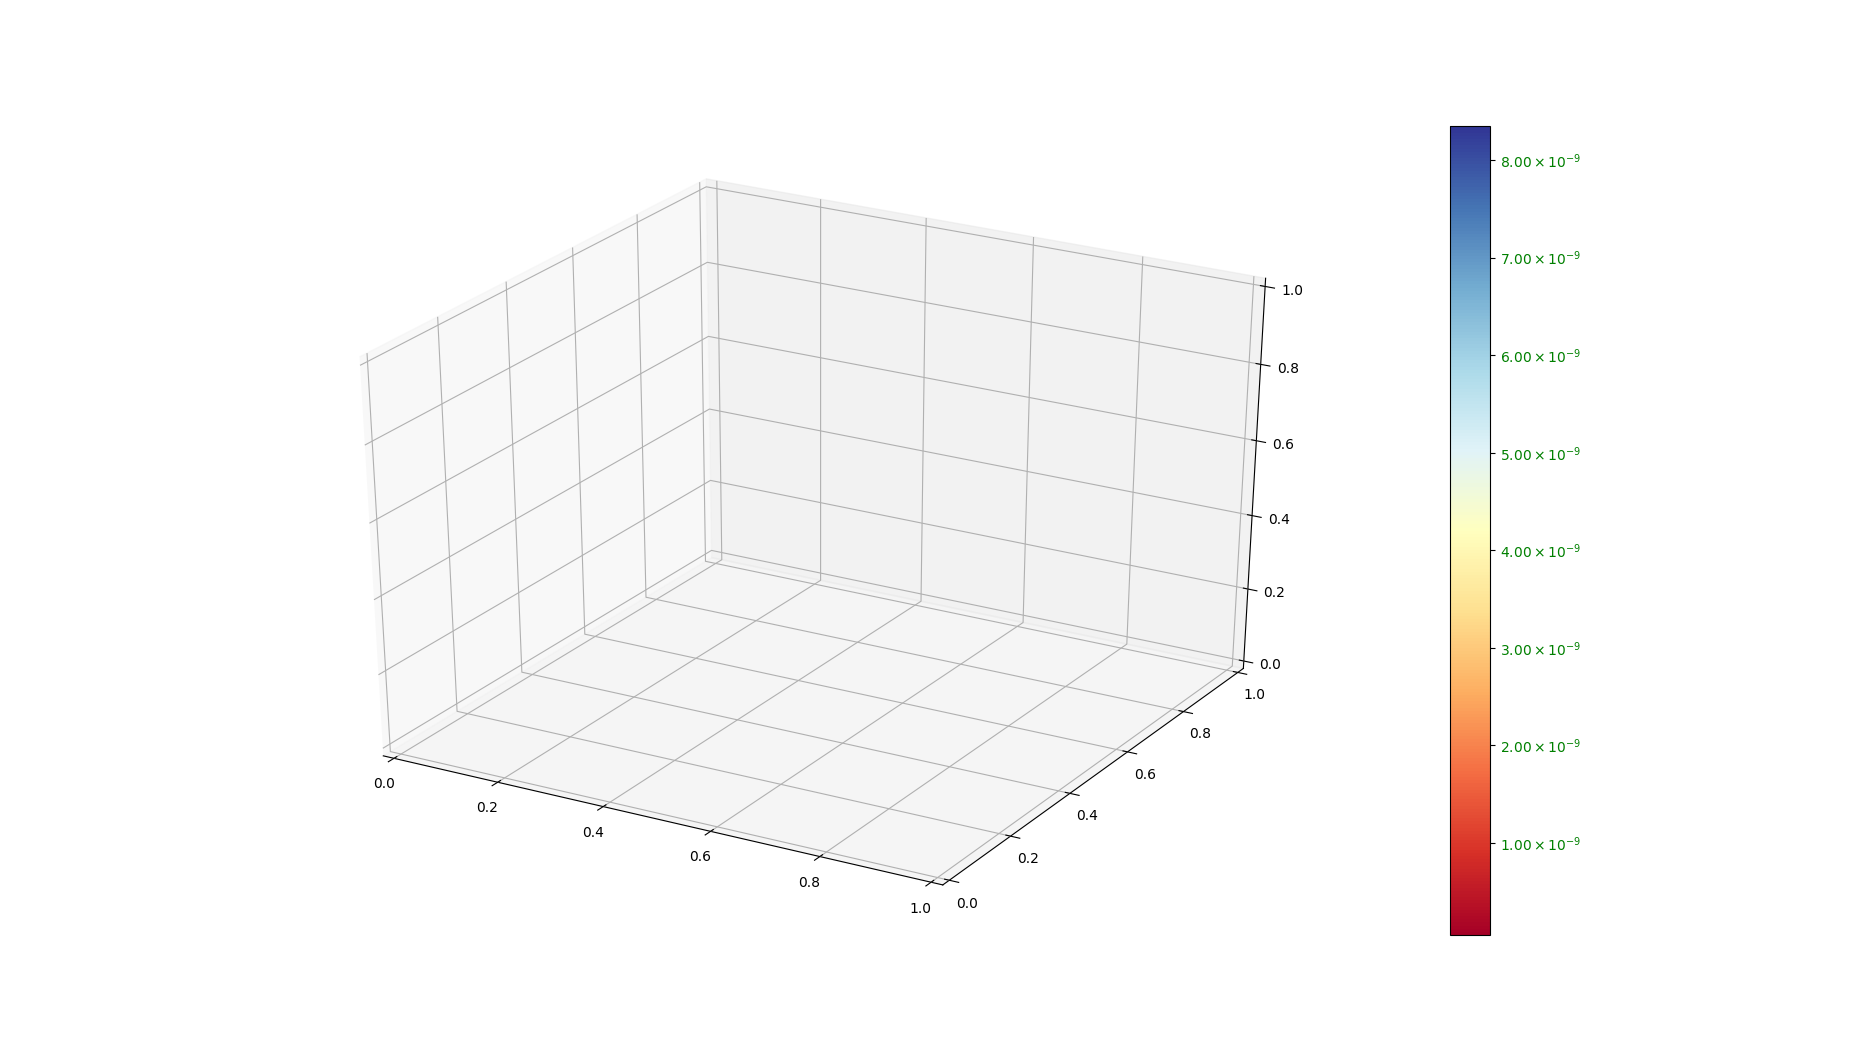

<IPython.core.display.Javascript object>


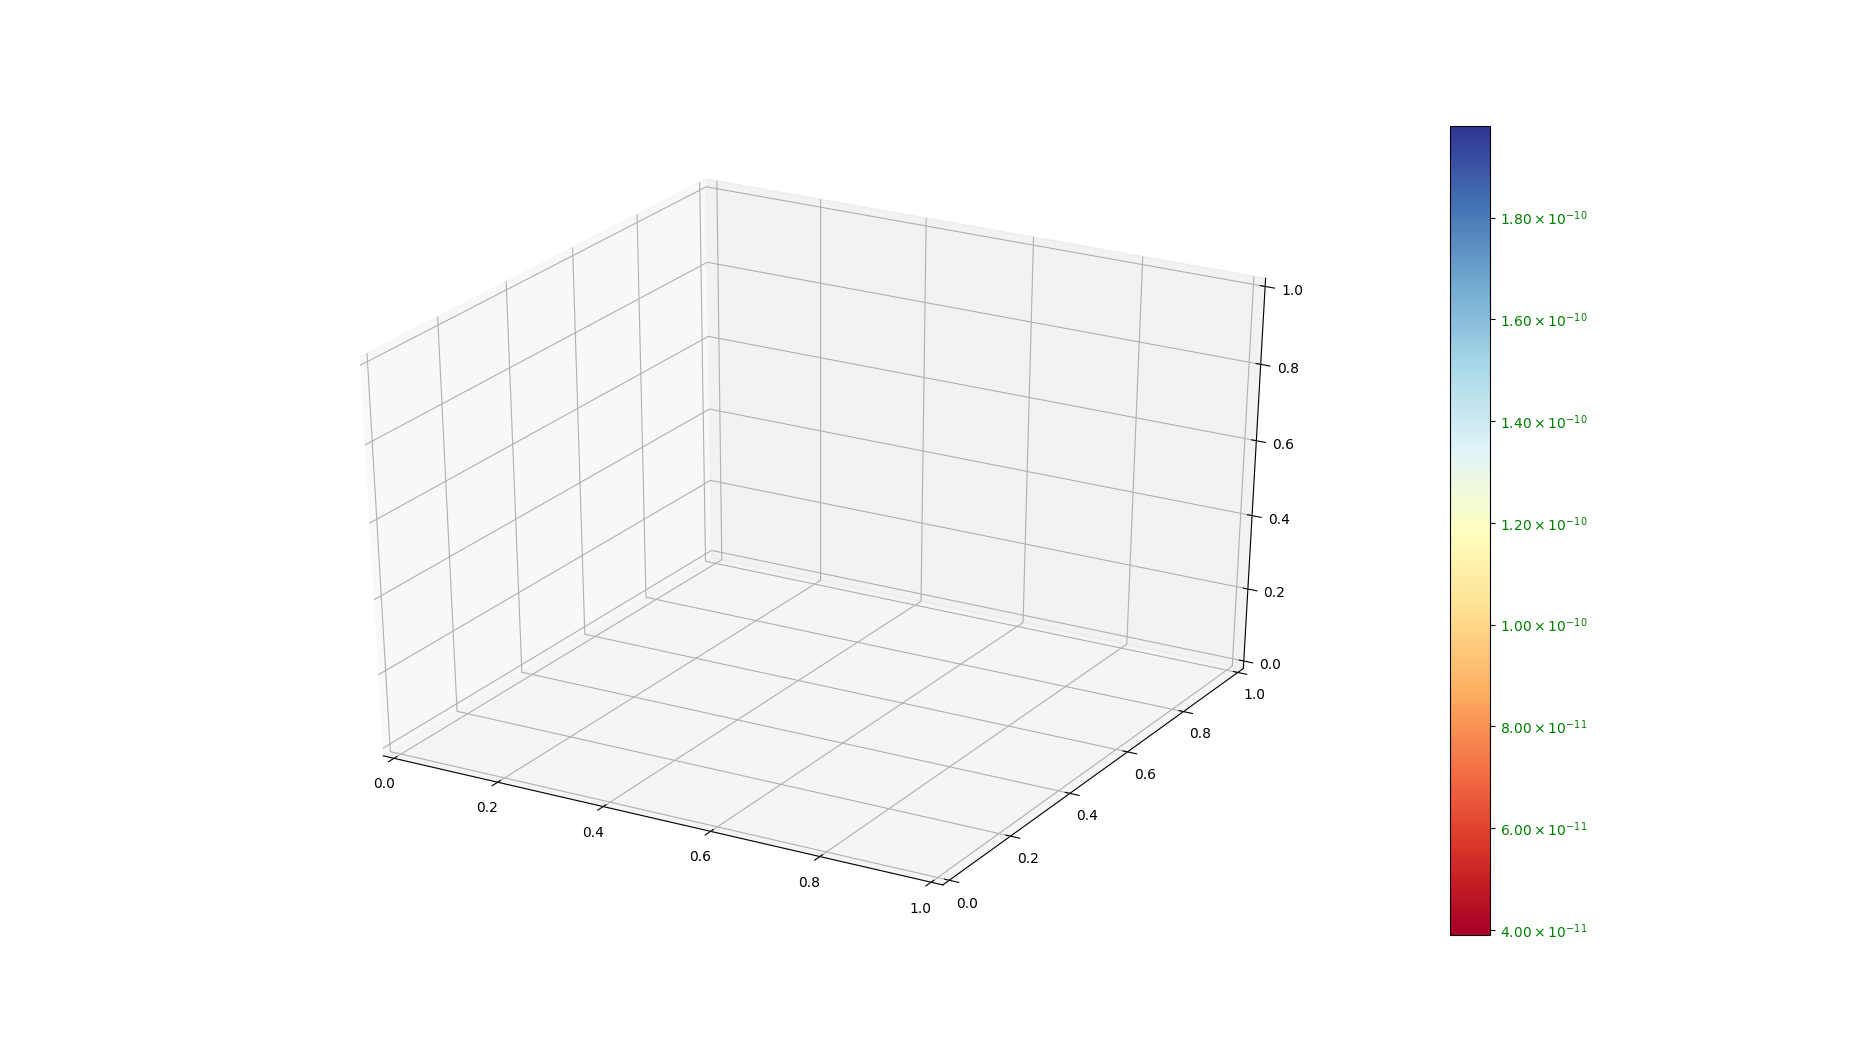

<IPython.core.display.Javascript object>


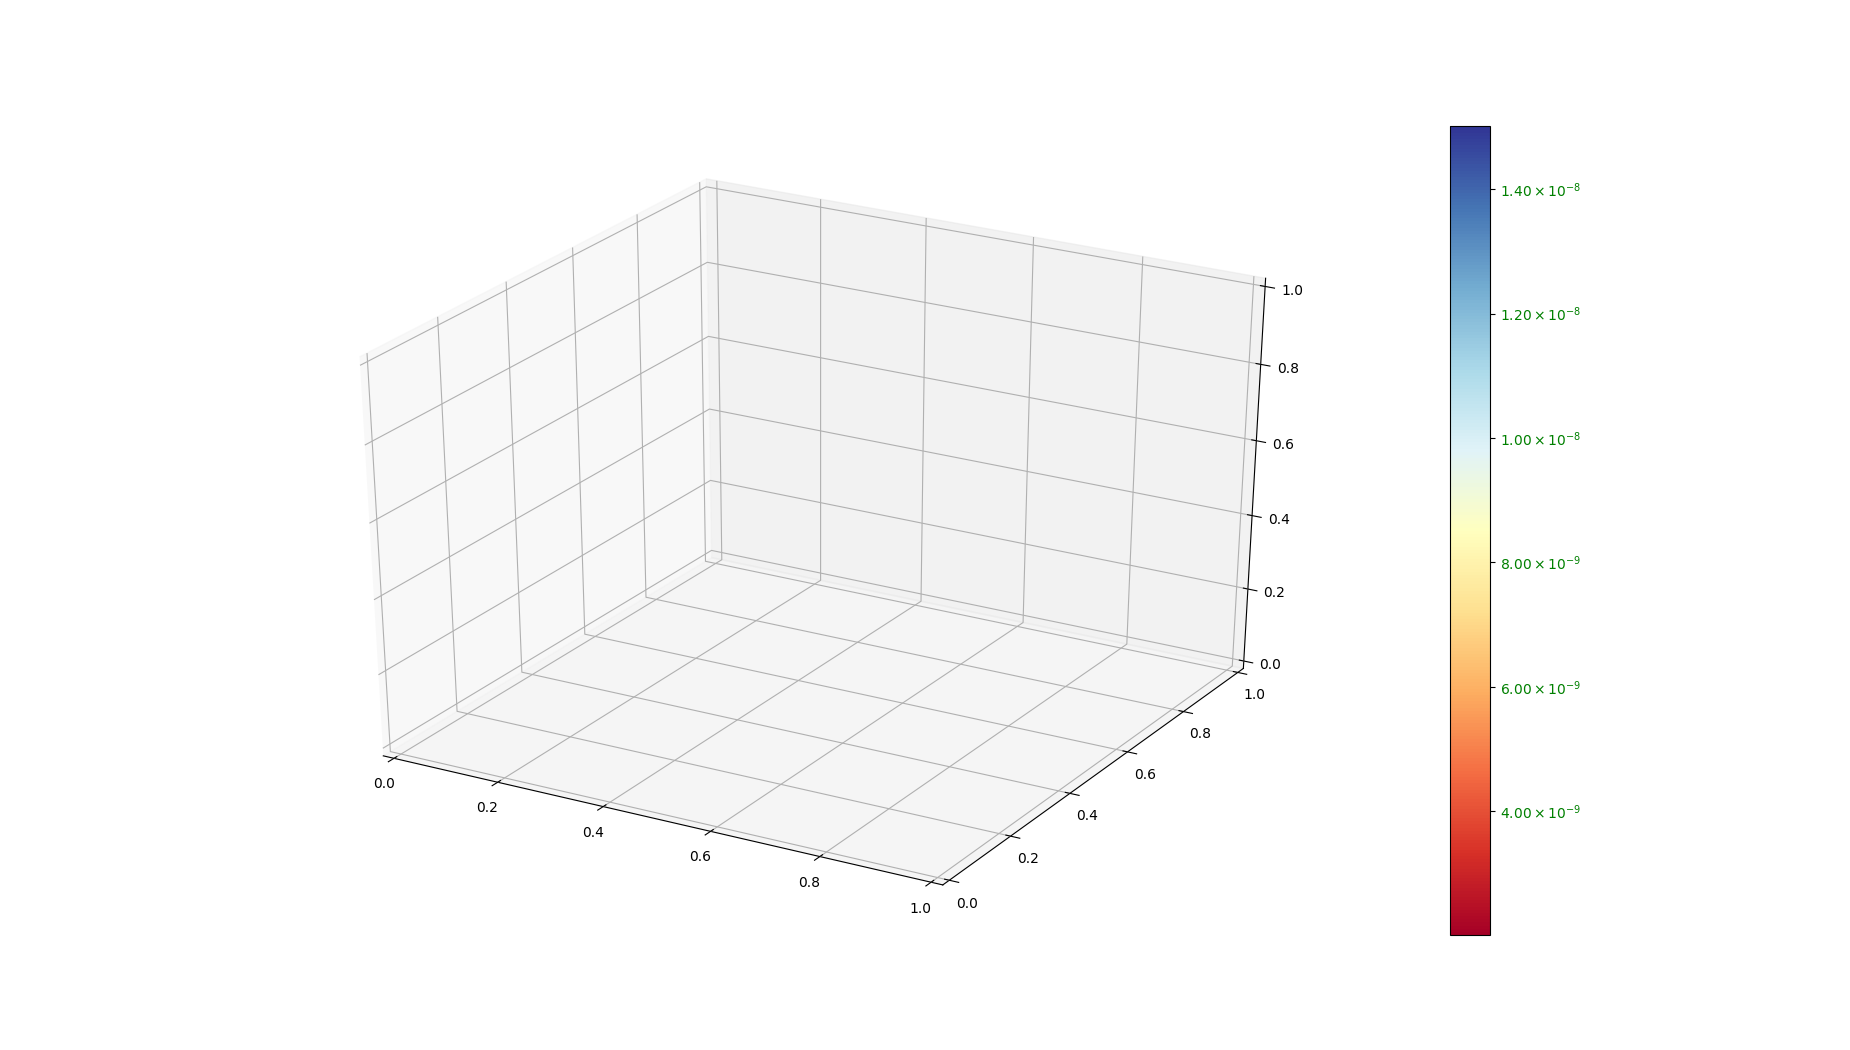

<IPython.core.display.Javascript object>


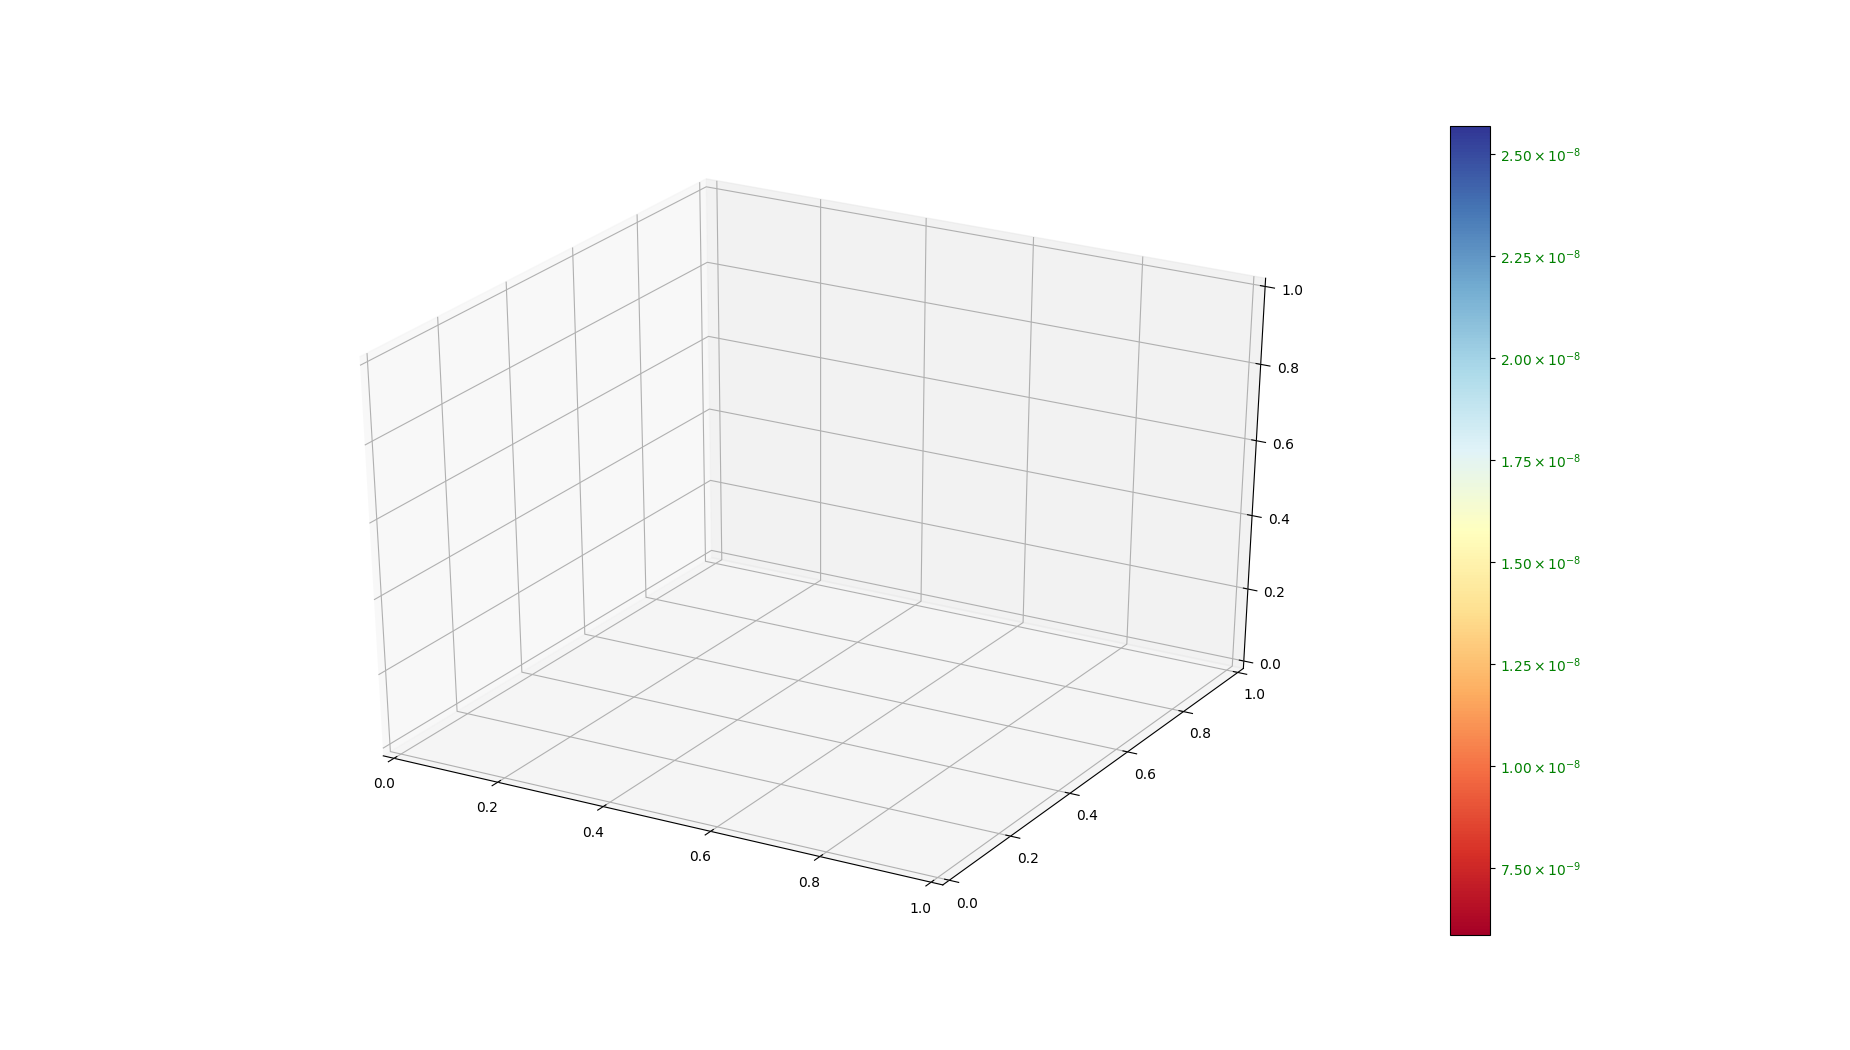

<IPython.core.display.Javascript object>


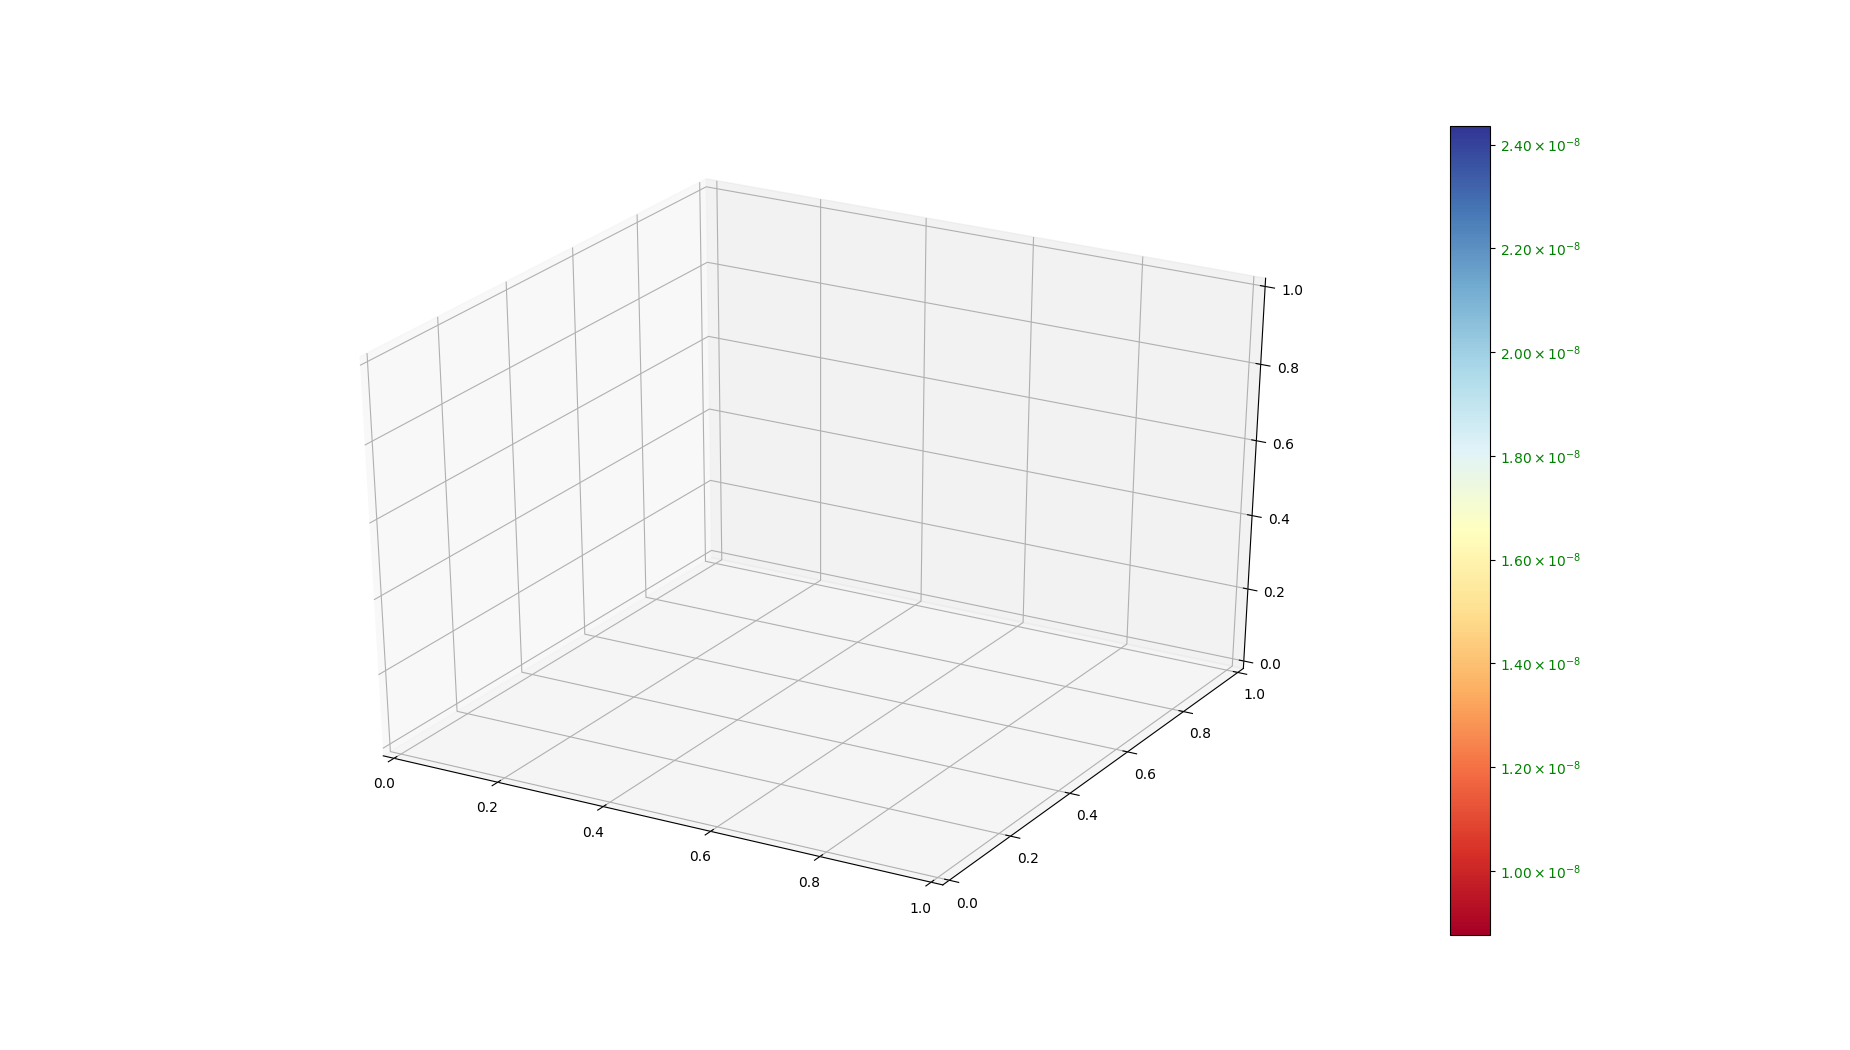

<IPython.core.display.Javascript object>


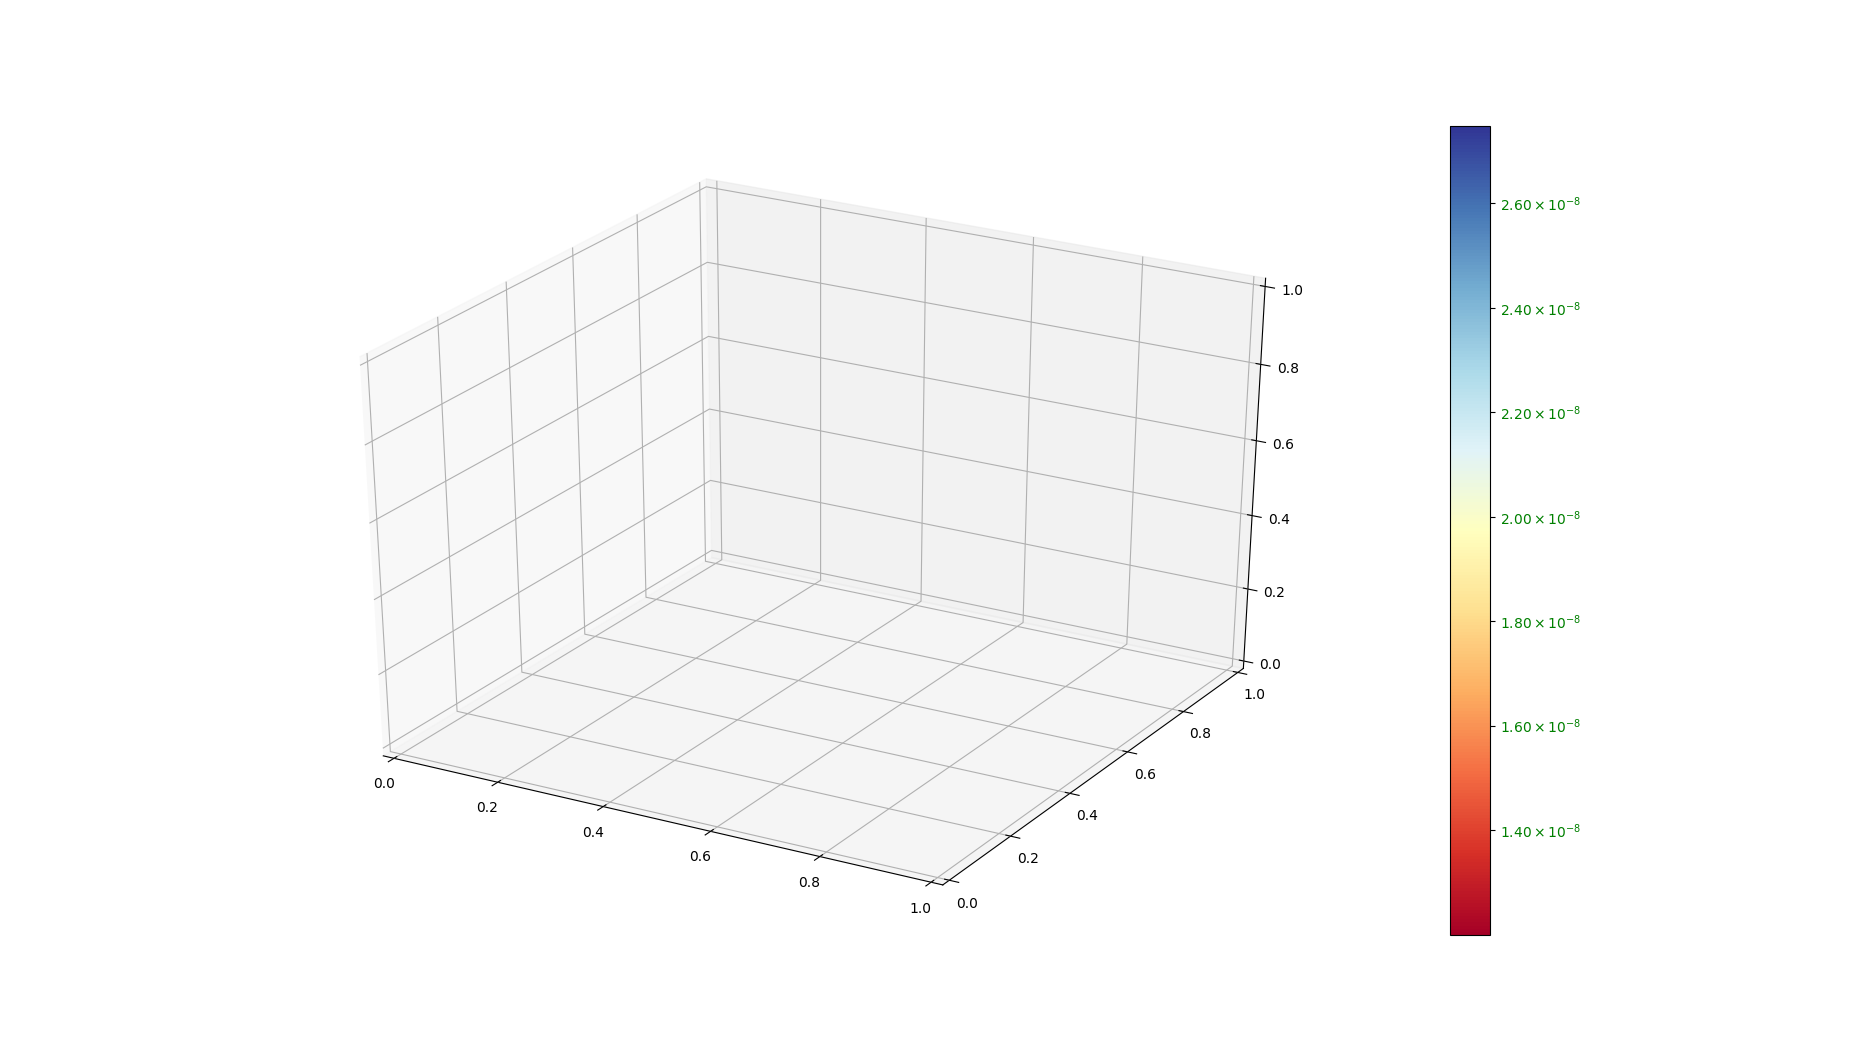

<IPython.core.display.Javascript object>


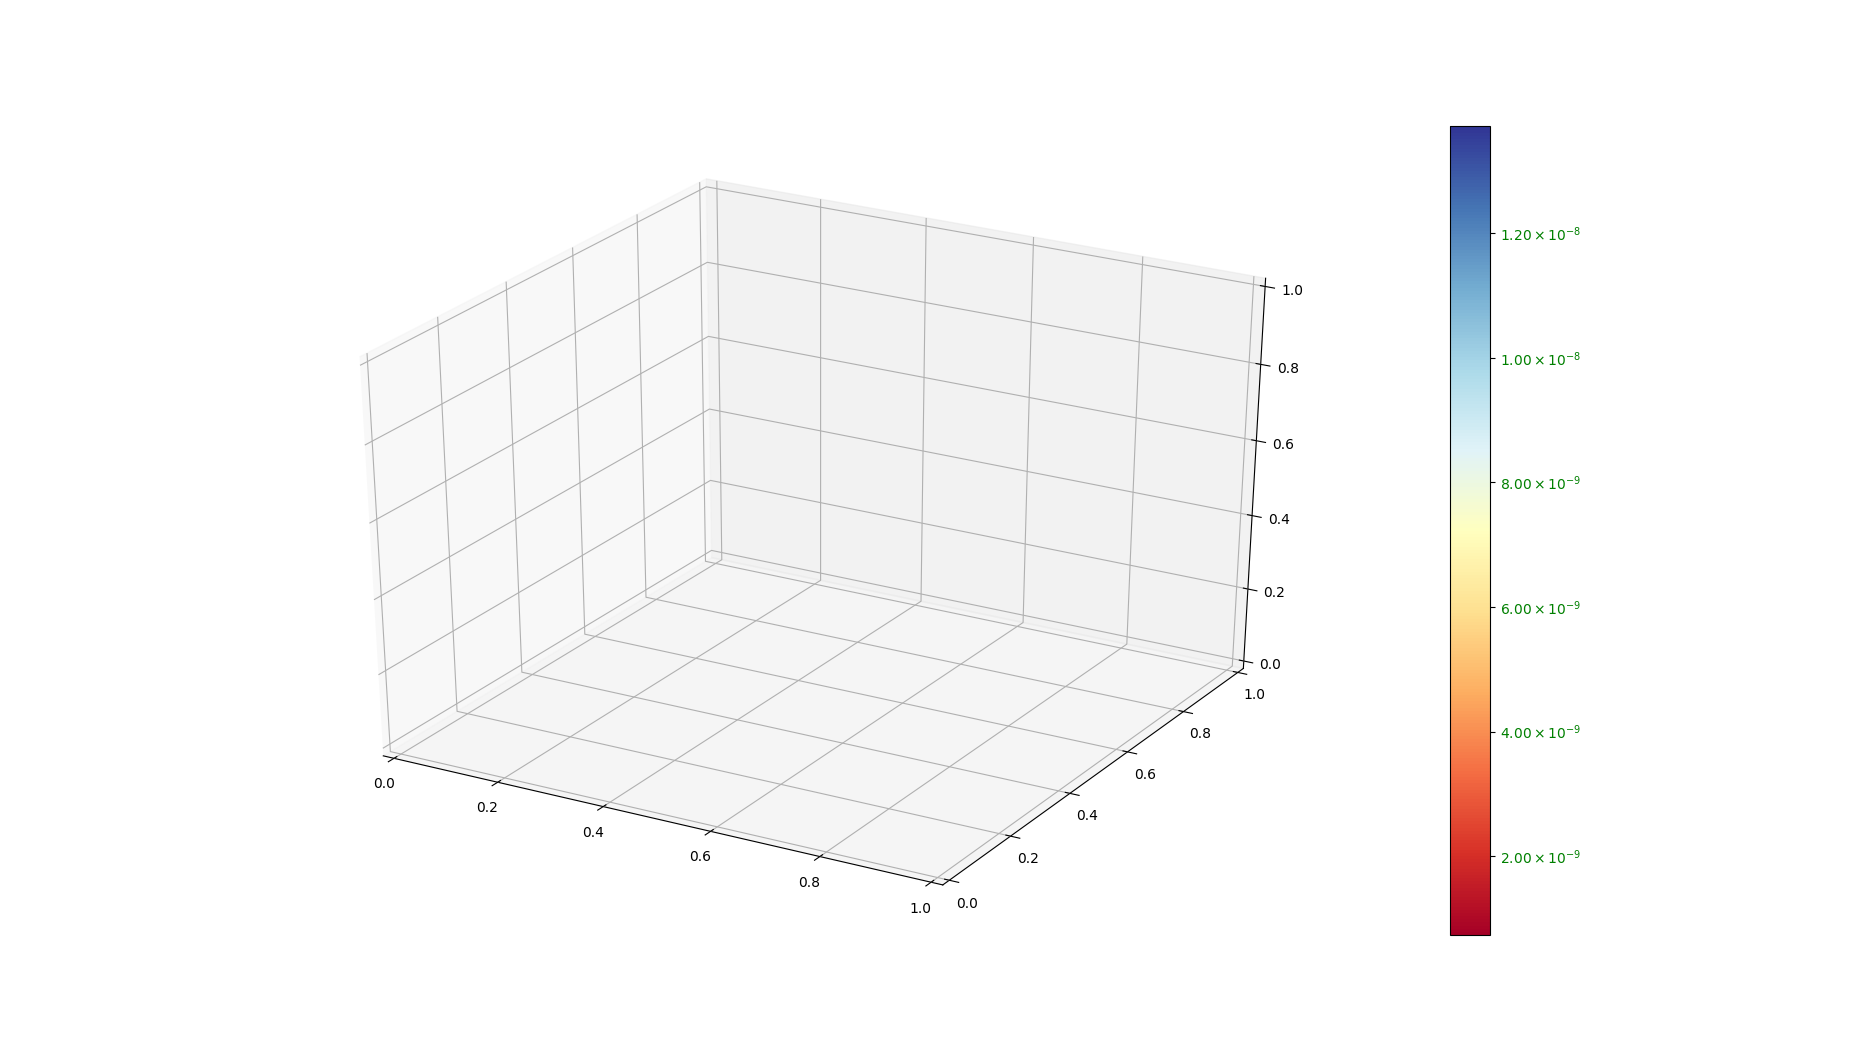

In [41]:
#Just ffmpeg everything, i tried doing fancy stuff with matplotlib animation but working with 3d colorbar 
#animation is a a nightmare, worst comes to worst host a subprocess and ffmpeg that way 

for i in range(0, len(snap_list)):
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    min_NSNS, max_NSNS = min(snap_NSNS[i]), max(snap_NSNS[i])

    cm = plt.cm.get_cmap('RdYlBu')

    star_plot = ax.scatter(snap_x[i], snap_y[i], snap_z[i], s=5, c=snap_NSNS[i], vmin=min_NSNS, vmax=max_NSNS, cmap=cm)
    ax.set_xlabel('ckpc/h')
    ax.set_ylabel('ckpc/h')
    ax.set_zlabel('ckpc/h')
    ax.set_title('snap: {}  subhalo: {}  particle type: {}'.format(snap_list[i], subhalo_id, 'gas'))

    #When you attach as email, the background is white so I had to change colobar tick colors
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    color_bar = plt.colorbar(star_plot, format=ticker.FuncFormatter(fmt))                   
    cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')
    plt.setp(cbytick_obj, color='g')
    fig.set_size_inches(18.5, 10.5)

    plt.savefig(cwd + "/Frames/frame{0:03d}".format(i))
    ax.clear()

There are a lot of variables and sometimes it is hard to remember what each one of them mean, this link http://www.tng-project.org/data/docs/specifications/#sec1a gives a description of all of these variables and a basic structure of the API.